In [ ]:
import torch
import itertools
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os
from tqdm import tqdm

In [ ]:
train_data = os.listdir('./Colton AI project/Myositis Images/train_data/')
train_label = os.listdir('./Colton AI project/Myositis Images/train_label/')
train_mask_label = os.listdir('./Colton AI project/Myositis Images/train_mask_label/')

In [ ]:
selected_data = set(['_'.join(_.split('_')[:4]) for _ in train_data])

In [ ]:
np.unique([_[:13] for _ in selected_data], return_counts=True)

(array(['121919_Myo089', '121919_Myo208', '121919_Myo231', '121919_Myo253',
        '121919_Myo368', '121919_Myo388', '121919_Myo511'], dtype='<U13'),
 array([36, 27,  8, 33, 52, 23,  9]))

In [ ]:
# train data (121): 121919_Myo089, 121919_Myo253, 121919_Myo368
# validation data (50): 121919_Myo208, 121919_Myo388
# test data (17): 121919_Myo231, 121919_Myo511 

In [ ]:
train_list = [[(_ + '_data_' + str(idx) + '.npy', _ + '_target_' + str(idx) + '.npy', _ + '_mask_' + str(idx) + '.npy') for idx in range(48)] 
              for _ in selected_data if _[:13] in ['121919_Myo089', '121919_Myo253', '121919_Myo368']]
validation_list = [[(_ + '_data_' + str(idx) + '.npy', _ + '_target_' + str(idx) + '.npy', _ + '_mask_' + str(idx) + '.npy') for idx in range(48)] 
                   for _ in selected_data if _[:13] in ['121919_Myo208', '121919_Myo388']]
test_list = [[(_ + '_data_' + str(idx) + '.npy', _ + '_target_' + str(idx) + '.npy', _ + '_mask_' + str(idx) + '.npy') for idx in range(48)] 
             for _ in selected_data if _[:13] in ['121919_Myo231', '121919_Myo511']]
train_list = list(itertools.chain(*train_list))
validation_list = list(itertools.chain(*validation_list))
test_list = list(itertools.chain(*test_list))
print('train data: {}'.format(len(train_list)))
print('validation data: {}'.format(len(validation_list)))
print('test data: {}'.format(len(test_list)))

train data: 5808
validation data: 2400
test data: 816


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):

        inputs = np.load('./Colton AI project/Myositis Images/train_data/' + self.file_list[idx][0])
        bdry = np.load('./Colton AI project/Myositis Images/train_label/' + self.file_list[idx][1])
        mask_label = np.load('./Colton AI project/Myositis Images/train_mask_label/' + self.file_list[idx][2])
        inputs = torch.from_numpy(inputs).unsqueeze(0)
        bdry = torch.from_numpy(bdry).unsqueeze(0)
        mask_label = torch.from_numpy(mask_label / 255).unsqueeze(0)
        label = torch.max(bdry * 2, mask_label).long().squeeze()

        if self.transform:
            inputs = self.transform(inputs)

        return (inputs, label, bdry, mask_label)

In [ ]:
dataloader = {}
dataloader['train'] = DataLoader(CustomDataset(train_list), batch_size=16, shuffle=True, num_workers=8, drop_last=False)
dataloader['validation'] = DataLoader(CustomDataset(validation_list), batch_size=16, shuffle=False, num_workers=8, drop_last=False)
dataloader['test'] = DataLoader(CustomDataset(test_list), batch_size=16, shuffle=False, num_workers=8, drop_last=False)

In [ ]:
datasize = {'train': len(train_list), 'validation': len(validation_list), 'test': len(test_list)}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
total_bkgd = {}
total_mask = {}
total_bdry = {}
for dat in ['train', 'validation', 'test']:
    bkgd_cnt = 0
    bdry_cnt = 0
    msk_cnt = 0
    for inputs, target, _, _ in dataloader[dat]:
        bkgd_cnt += torch.sum(target == 0).item()
        bdry_cnt += torch.sum(target == 2).item()
        msk_cnt += torch.sum(target == 1).item()
    total_bkgd[dat] = bkgd_cnt
    total_mask[dat] = msk_cnt
    total_bdry[dat] = bdry_cnt
    print('{} ratio of background : mask : boundary: \n {} : {} : {}'.format(dat, bkgd_cnt, msk_cnt, bdry_cnt))

train ratio of background : mask : boundary: 
 323726651 : 51071473 : 5834964
validation ratio of background : mask : boundary: 
 134066579 : 21038234 : 2181587
test ratio of background : mask : boundary: 
 48808088 : 4229959 : 439329


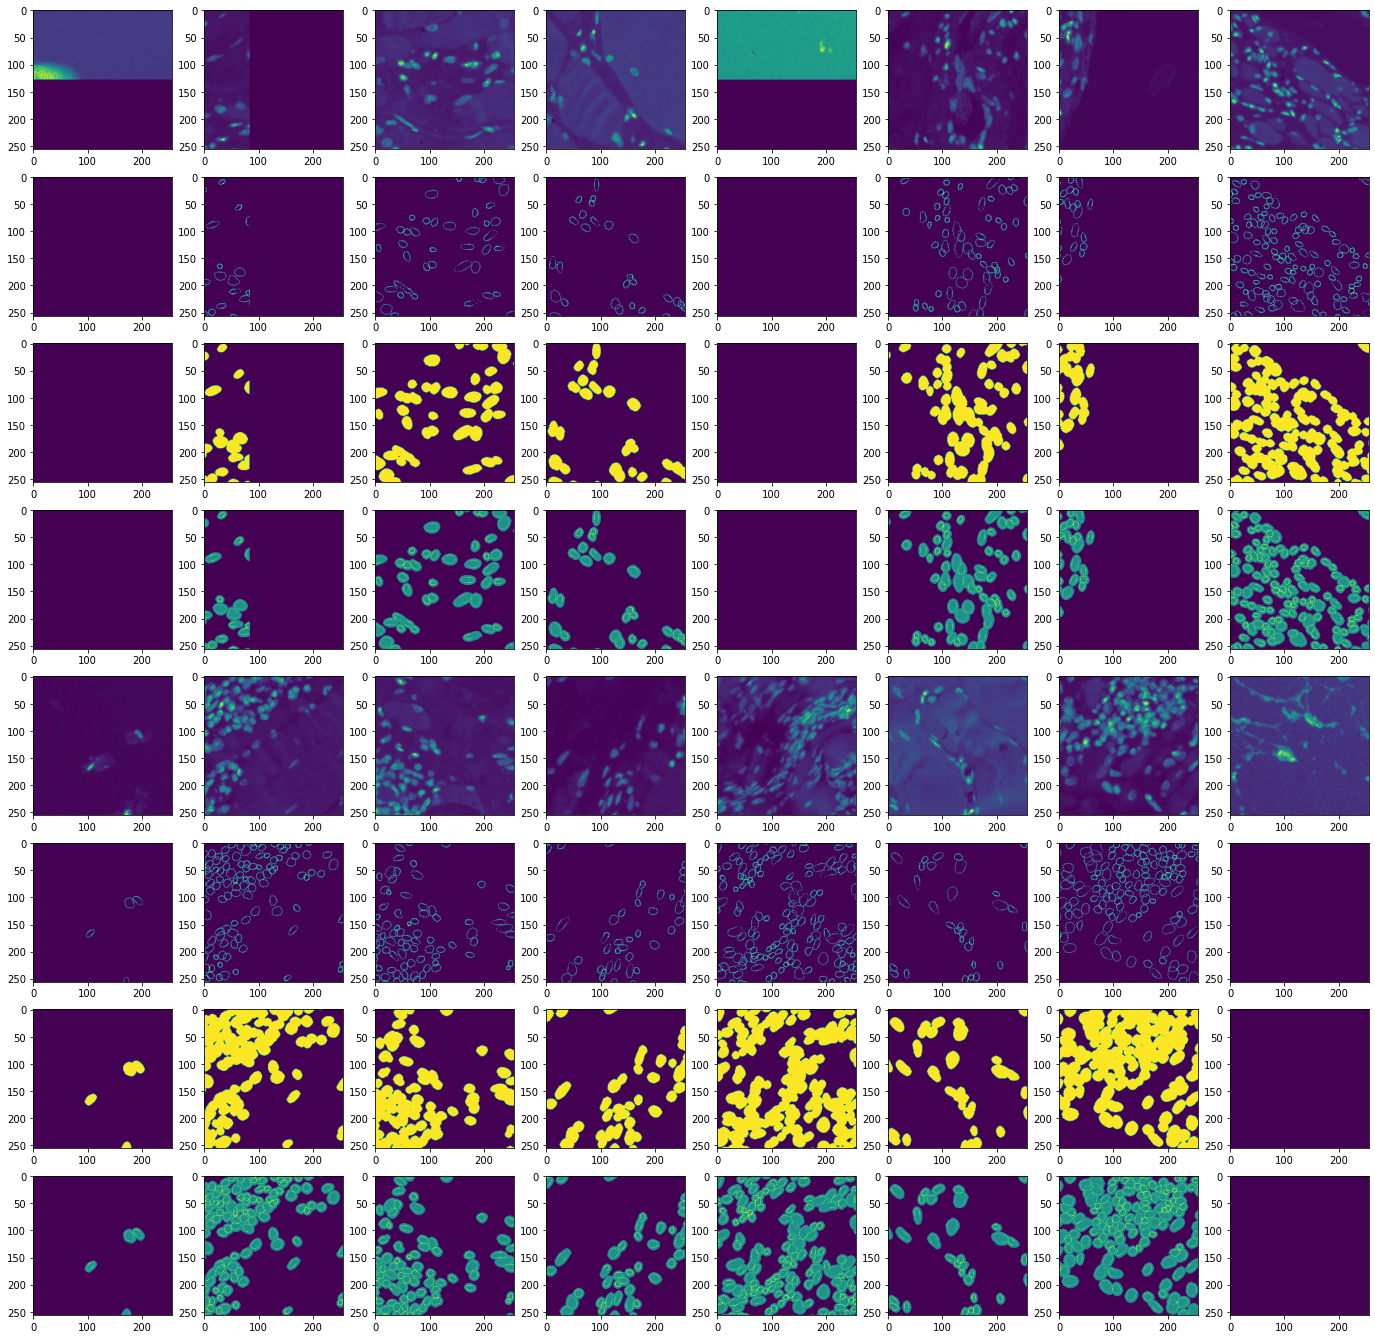

In [ ]:
inputs, labels, bdry, mask_label = next(iter(dataloader['train']))
plt.figure(figsize=(24,24))
for _ in range(8):
    plt.subplot(8,8,_+1)
    plt.imshow(inputs[_].squeeze().numpy())
    plt.subplot(8,8,_+9)
    plt.imshow(bdry[_].squeeze().numpy())
    plt.subplot(8,8,_+17)
    plt.imshow(mask_label[_].squeeze().numpy())
    plt.subplot(8,8,_+25)
    plt.imshow(labels[_].squeeze().numpy())
for _ in range(8,16):
    plt.subplot(8,8,_+25)
    plt.imshow(inputs[_].squeeze().numpy())
    plt.subplot(8,8,_+33)
    plt.imshow(bdry[_].squeeze().numpy())
    plt.subplot(8,8,_+41)
    plt.imshow(mask_label[_].squeeze().numpy())
    plt.subplot(8,8,_+49)
    plt.imshow(labels[_].squeeze().numpy())
plt.show()

# UNet

In [ ]:
from collections import OrderedDict

class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder5 = UNet._block(features * 8, features * 16, name="enc5")
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 16, features * 32, name="bottleneck")
        
        self.upconv5 = nn.ConvTranspose2d(
            features * 32, features * 16, kernel_size=2, stride=2
        )
        self.decoder5 = UNet._block((features * 16) * 2, features * 16, name="dec5")
        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        enc5 = self.encoder5(self.pool4(enc4))

        bottleneck = self.bottleneck(self.pool5(enc5))

        dec5 = self.upconv5(bottleneck)
        dec5 = torch.cat((dec5, enc5), dim=1)
        dec5 = self.decoder5(dec5)
        dec4 = self.upconv4(dec5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

# Cross-entropy Loss

In [ ]:
class DiceLoss(nn.Module):
    # reduction = 'sum'
    def __init__(self, device):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0
        self.one = torch.ones(1, requires_grad=True, device=device)

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return self.one - dsc

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, maximum_patient=5):
    since = time.time()
    
    init_model_wts = copy.deepcopy(model.state_dict())
    best_pos_model_wts = copy.deepcopy(model.state_dict())
    best_neg_model_wts = copy.deepcopy(model.state_dict())
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 0.0
    patient_count = 0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0
            running_bdry = 0.0
            running_mask = 0.0
            running_bkgd = 0.0

            # Iterate over data.
            for inputs, target, bdry, mask in dataloader[phase]:
                inputs = inputs.to(device)
                target = target.to(device)
                bdry = bdry.squeeze().to(device)
                mask = mask.squeeze().to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    pred = torch.argmax(outputs, dim=1)
                    loss = criterion(outputs, target)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(pred == target).item()
                running_bdry += torch.sum(pred[bdry.bool()] == 2).item()
                running_mask += torch.sum(pred[mask.bool()] == 1).item()
                running_bkgd += torch.sum(pred[~mask.bool()] == 0).item()
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / datasize[phase]
            epoch_acc = running_corrects / (datasize[phase] * inputs.size()[1] * inputs.size()[2] * inputs.size()[3])
            epoch_bdry = running_bdry / total_bdry[phase]
            epoch_mask = running_mask / total_mask[phase]
            epoch_bkgd = running_bkgd / total_bkgd[phase]

            print('{} Loss: {:.4f} Boundary Acc: {:.4f} Mask Acc: {:.4f} Background Acc: {:.4f} Overall Acc: {:.4f}'.format(phase, epoch_loss, epoch_bdry, epoch_mask, epoch_bkgd, epoch_acc))

            # deep copy the model
            if phase == 'validation':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save({'model': model, 'optimizer': optimizer, 'scheduler': scheduler.state_dict(), 'loss': criterion, 
                                'loss_state': criterion.state_dict(), 'epoch': epoch, 'initial_state': init_model_wts}, 
                               './Colton AI project/Myositis Images/model/unet_ovracc_{:.3f}_bkgdacc_{:.3f}_mskacc_{:.3f}_bdryacc_{:.3f}.pt'.format(epoch_acc, epoch_bkgd, epoch_mask, epoch_bdry))
                    print('model saved!')
                    patient_count = 0
                else:
                    patient_count += 1
                    
        if patient_count > maximum_patient:
            break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Overall Acc: {:4f}'.format(best_acc))

In [ ]:
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#     in_channels=1, out_channels=3, init_features=32, pretrained=False) # https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
model = UNet(in_channels=1, out_channels=3, init_features=32)
model = model.to(device)
criterion = nn.CrossEntropyLoss(reduction='sum', weight=torch.tensor([1.,6.,60.]).to(device))
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
train_model(model, criterion, optimizer, scheduler, maximum_patient=5)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/24
----------
train Loss: 134993.0456 Boundary Acc: 0.5712 Mask Acc: 0.5091 Background Acc: 0.9367 Overall Acc: 0.8679
validation Loss: 126300.6432 Boundary Acc: 0.8608 Mask Acc: 0.4117 Background Acc: 0.8952 Overall Acc: 0.8283


  4%|▍         | 1/25 [01:02<25:02, 62.62s/it]

model saved!

Epoch 1/24
----------
train Loss: 131645.1131 Boundary Acc: 0.8022 Mask Acc: 0.4337 Background Acc: 0.9470 Overall Acc: 0.8735
validation Loss: 123725.7990 Boundary Acc: 0.9175 Mask Acc: 0.3760 Background Acc: 0.9494 Overall Acc: 0.8713


  8%|▊         | 2/25 [02:04<23:56, 62.45s/it]

model saved!

Epoch 2/24
----------
train Loss: 131028.7319 Boundary Acc: 0.8413 Mask Acc: 0.4206 Background Acc: 0.9489 Overall Acc: 0.8745


 12%|█▏        | 3/25 [03:05<22:40, 61.83s/it]

validation Loss: 125038.3492 Boundary Acc: 0.9392 Mask Acc: 0.3545 Background Acc: 0.9258 Overall Acc: 0.8489

Epoch 3/24
----------
train Loss: 128408.2664 Boundary Acc: 0.7867 Mask Acc: 0.6331 Background Acc: 0.9468 Overall Acc: 0.8995
validation Loss: 124931.5905 Boundary Acc: 0.8070 Mask Acc: 0.7320 Background Acc: 0.9131 Overall Acc: 0.8849


 16%|█▌        | 4/25 [04:06<21:36, 61.73s/it]

model saved!

Epoch 4/24
----------
train Loss: 125710.0746 Boundary Acc: 0.8079 Mask Acc: 0.7310 Background Acc: 0.9467 Overall Acc: 0.9131


 20%|██        | 5/25 [05:07<20:27, 61.38s/it]

validation Loss: 116307.2598 Boundary Acc: 0.7964 Mask Acc: 0.7760 Background Acc: 0.9056 Overall Acc: 0.8840

Epoch 5/24
----------
train Loss: 116943.8936 Boundary Acc: 0.8745 Mask Acc: 0.7199 Background Acc: 0.9448 Overall Acc: 0.9119
validation Loss: 112366.2710 Boundary Acc: 0.8926 Mask Acc: 0.7017 Background Acc: 0.9458 Overall Acc: 0.9110


 24%|██▍       | 6/25 [06:08<19:27, 61.46s/it]

model saved!

Epoch 6/24
----------
train Loss: 116490.7856 Boundary Acc: 0.8771 Mask Acc: 0.7251 Background Acc: 0.9451 Overall Acc: 0.9129
validation Loss: 112028.5671 Boundary Acc: 0.8844 Mask Acc: 0.7227 Background Acc: 0.9437 Overall Acc: 0.9118


 28%|██▊       | 7/25 [07:10<18:25, 61.40s/it]

model saved!

Epoch 7/24
----------
train Loss: 116233.8936 Boundary Acc: 0.8770 Mask Acc: 0.7285 Background Acc: 0.9463 Overall Acc: 0.9144
validation Loss: 111769.6127 Boundary Acc: 0.8976 Mask Acc: 0.7037 Background Acc: 0.9505 Overall Acc: 0.9154


 32%|███▏      | 8/25 [08:10<17:20, 61.20s/it]

model saved!

Epoch 8/24
----------
train Loss: 116028.0731 Boundary Acc: 0.8782 Mask Acc: 0.7296 Background Acc: 0.9471 Overall Acc: 0.9153
validation Loss: 111184.3059 Boundary Acc: 0.8912 Mask Acc: 0.7168 Background Acc: 0.9583 Overall Acc: 0.9237


 36%|███▌      | 9/25 [09:11<16:18, 61.14s/it]

model saved!

Epoch 9/24
----------
train Loss: 115749.0240 Boundary Acc: 0.8805 Mask Acc: 0.7316 Background Acc: 0.9477 Overall Acc: 0.9161


 40%|████      | 10/25 [10:11<15:10, 60.73s/it]

validation Loss: 111641.8796 Boundary Acc: 0.8781 Mask Acc: 0.7351 Background Acc: 0.9462 Overall Acc: 0.9154

Epoch 10/24
----------
train Loss: 115401.6618 Boundary Acc: 0.8828 Mask Acc: 0.7347 Background Acc: 0.9483 Overall Acc: 0.9171


 44%|████▍     | 11/25 [11:10<14:04, 60.33s/it]

validation Loss: 111181.7991 Boundary Acc: 0.8939 Mask Acc: 0.7196 Background Acc: 0.9509 Overall Acc: 0.9178

Epoch 11/24
----------
train Loss: 115389.4095 Boundary Acc: 0.8824 Mask Acc: 0.7353 Background Acc: 0.9485 Overall Acc: 0.9174


 48%|████▊     | 12/25 [12:10<12:59, 60.00s/it]

validation Loss: 111019.0949 Boundary Acc: 0.8944 Mask Acc: 0.7217 Background Acc: 0.9525 Overall Acc: 0.9195

Epoch 12/24
----------


# visualize cross entropy loss model

In [ ]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=1, out_channels=3, init_features=32, pretrained=False) # https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
model_load = torch.load('./Colton AI project/Myositis Images/model/unet_acc_{:.3f}.pt'.format(0.926), map_location=device)
model = model_load['model'].to(device)

Using cache found in /home/fz477/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [ ]:
model = UNet(in_channels=1, out_channels=3, init_features=32)
model_load = torch.load('./Colton AI project/Myositis Images/model/unet_ovracc_{:.3f}_bkgdacc_{:.3f}_mskacc_{:.3f}_bdryacc_{:.3f}.pt'.format(0.913, 0.948, 0.704, 0.887))
model = model_load['model'].to(device)

In [ ]:
model.eval()   # Set model to evaluate mode

running_corrects = 0
running_bdry = 0.0
running_mask = 0.0
running_bkgd = 0.0
phase = 'validation'

# Iterate over data.
for inputs, target, bdry, mask in dataloader[phase]:
    inputs = inputs.to(device)
    target = target.to(device)
    bdry = bdry.squeeze().to(device)
    mask = mask.squeeze().to(device)

    outputs = model(inputs)
    pred = torch.argmax(outputs, dim=1)

    # statistics
    running_corrects += torch.sum(target == pred)
    running_bdry += torch.sum(pred[bdry.bool()] == 2).item()
    running_mask += torch.sum(pred[mask.bool()] == 1).item()
    running_bkgd += torch.sum(pred[~mask.bool()] == 0).item()
    
epoch_acc = running_corrects.item() / (datasize[phase] * inputs.size()[1] * inputs.size()[2] * inputs.size()[3])
epoch_bdry = running_bdry / total_bdry[phase]
epoch_mask = running_mask / total_mask[phase]
epoch_bkgd = running_bkgd / total_bkgd[phase]
print('{} Boundary Acc: {:.4f} Mask Acc: {:.4f} Background Acc: {:.4f} Overall Acc: {:.4f}'.format(phase, epoch_bdry, epoch_mask, epoch_bkgd, epoch_acc))

validation Boundary Acc: 0.8866 Mask Acc: 0.7041 Background Acc: 0.9477 Overall Acc: 0.9128


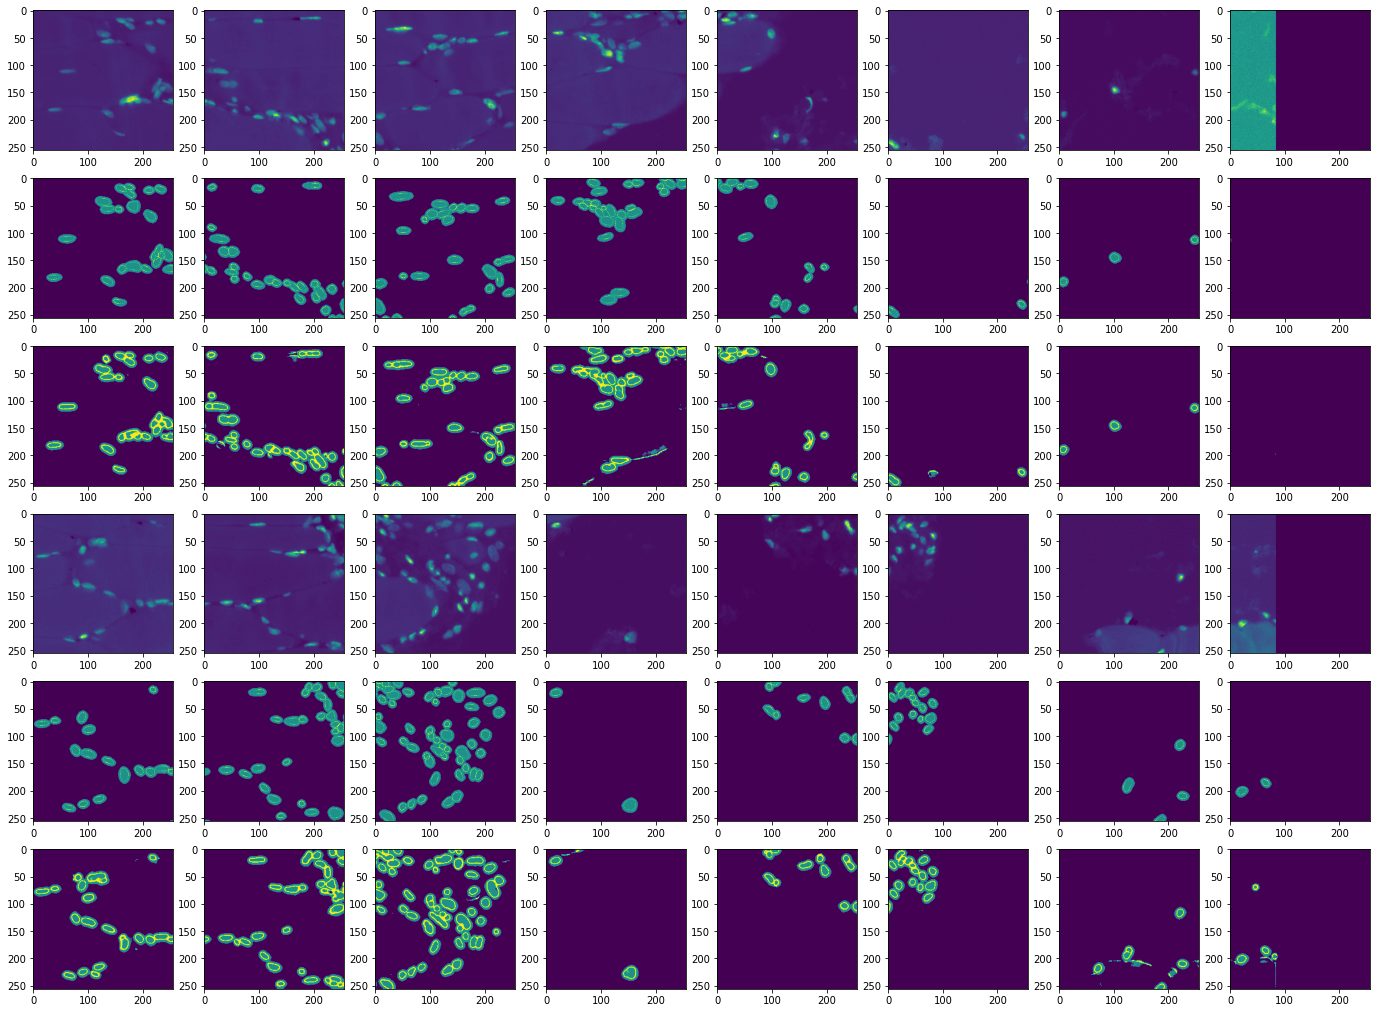

In [ ]:
inputs, target, _, _ = next(iter(dataloader['validation']))
outputs = model.cpu()(inputs)
outputs = torch.argmax(outputs, dim=1)

plt.figure(figsize=(24,18))
for _ in range(8):
    plt.subplot(6,8,_+1)
    plt.imshow(inputs[_].squeeze().numpy())
    plt.subplot(6,8,_+9)
    plt.imshow(target[_].squeeze().numpy())
    plt.subplot(6,8,_+17)
    plt.imshow(outputs[_].squeeze().cpu().numpy())
for _ in range(8,16):
    plt.subplot(6,8,_+17)
    plt.imshow(inputs[_].squeeze().numpy())
    plt.subplot(6,8,_+25)
    plt.imshow(target[_].squeeze().numpy())
    plt.subplot(6,8,_+33)
    plt.imshow(outputs[_].squeeze().cpu().numpy())
    
plt.show()

In [ ]:
model = model_load['model'].to(device)
model.eval()   # Set model to evaluate mode

running_corrects = 0
running_bdry = 0.0
running_mask = 0.0
running_bkgd = 0.0
phase = 'test'

# Iterate over data.
for inputs, target, bdry, mask in dataloader[phase]:
    inputs = inputs.to(device)
    target = target.to(device)
    bdry = bdry.squeeze().to(device)
    mask = mask.squeeze().to(device)

    outputs = model(inputs)
    pred = torch.argmax(outputs, dim=1)

    # statistics
    running_corrects += torch.sum(target == pred)
    running_bdry += torch.sum(pred[bdry.bool()] == 2).item()
    running_mask += torch.sum(pred[mask.bool()] == 1).item()
    running_bkgd += torch.sum(pred[~mask.bool()] == 0).item()
    
epoch_acc = running_corrects.item() / (datasize[phase] * inputs.size()[1] * inputs.size()[2] * inputs.size()[3])
epoch_bdry = running_bdry / total_bdry[phase]
epoch_mask = running_mask / total_mask[phase]
epoch_bkgd = running_bkgd / total_bkgd[phase]
print('{} Boundary Acc: {:.4f} Mask Acc: {:.4f} Background Acc: {:.4f} Overall Acc: {:.4f}'.format(phase, epoch_bdry, epoch_mask, epoch_bkgd, epoch_acc))

test Boundary Acc: 0.8624 Mask Acc: 0.7291 Background Acc: 0.9588 Overall Acc: 0.9389


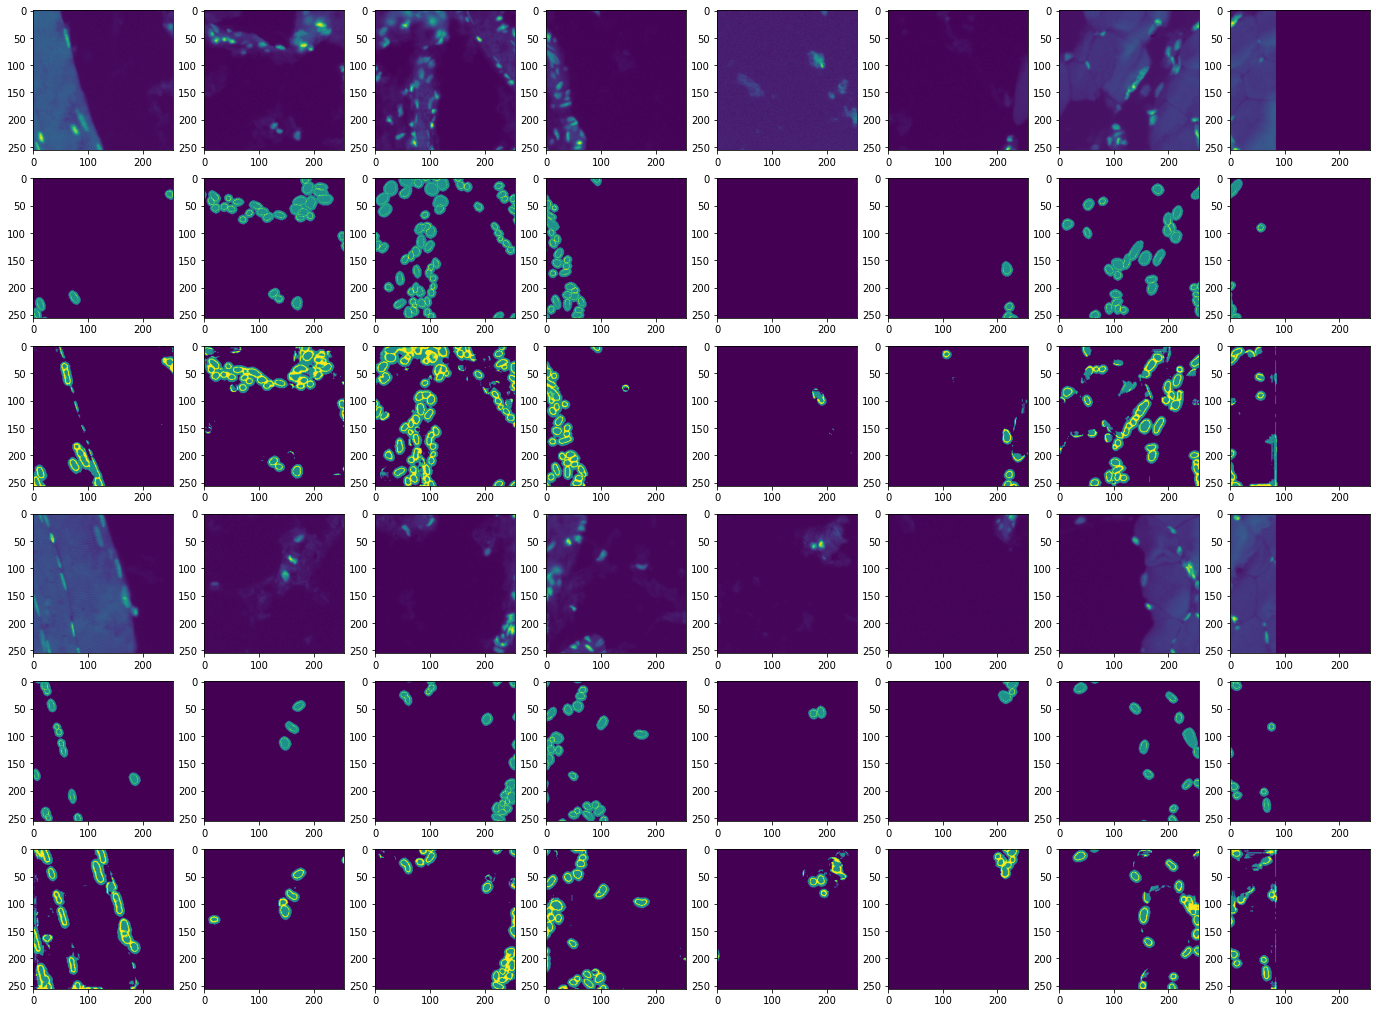

In [ ]:
inputs, target, _, _ = next(iter(dataloader['test']))
outputs = model.cpu()(inputs)
outputs = torch.argmax(outputs, dim=1)

plt.figure(figsize=(24,18))
for _ in range(8):
    plt.subplot(6,8,_+1)
    plt.imshow(inputs[_].squeeze().numpy())
    plt.subplot(6,8,_+9)
    plt.imshow(target[_].squeeze().numpy())
    plt.subplot(6,8,_+17)
    plt.imshow(outputs[_].squeeze().cpu().numpy())
for _ in range(8,16):
    plt.subplot(6,8,_+17)
    plt.imshow(inputs[_].squeeze().numpy())
    plt.subplot(6,8,_+25)
    plt.imshow(target[_].squeeze().numpy())
    plt.subplot(6,8,_+33)
    plt.imshow(outputs[_].squeeze().cpu().numpy())
    
plt.show()